In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import seaborn as sns
from visualization_helper import init_plot_style
from conversation_helper import conversation_filter

In [2]:
init_plot_style()

In [3]:
%%time
ds = pd.read_csv('/Users/john/data/twitter/twconvcharact/tweets_ec_nd_conv.csv', 
        usecols=['id', 
                 'conversation_id',
                 'num_replies',
                 'created_at',
                ],
                 dtype={
                     'in_reply_to_status_id': object,
                       },
                 #parse_dates=['timestamp'],
                )
ds.shape

CPU times: user 9.67 s, sys: 1.05 s, total: 10.7 s
Wall time: 10.9 s


In [6]:
ds['timestamp'] = pd.to_datetime(ds['created_at'])

In [7]:
print(ds.timestamp.min())
print(ds.timestamp.max())

2009-03-07 17:57:46
2017-07-12 21:13:54


In [8]:
ds['created']=ds.timestamp.dt.date
ds.head()

,id,created_at,conversation_id,num_replies,timestamp,created
0,838977507487547393,Tue Mar 07 04:59:59 +0000 2017,838920932982992896,94,2017-03-07 04:59:59,2017-03-07
1,838977593403666432,Tue Mar 07 05:00:20 +0000 2017,838920932982992896,94,2017-03-07 05:00:20,2017-03-07
2,838978411460767745,Tue Mar 07 05:03:35 +0000 2017,838920932982992896,94,2017-03-07 05:03:35,2017-03-07
3,838997472966021120,Tue Mar 07 06:19:20 +0000 2017,838920932982992896,94,2017-03-07 06:19:20,2017-03-07
4,838999765996224512,Tue Mar 07 06:28:26 +0000 2017,838920932982992896,94,2017-03-07 06:28:26,2017-03-07


(10000, 27812)

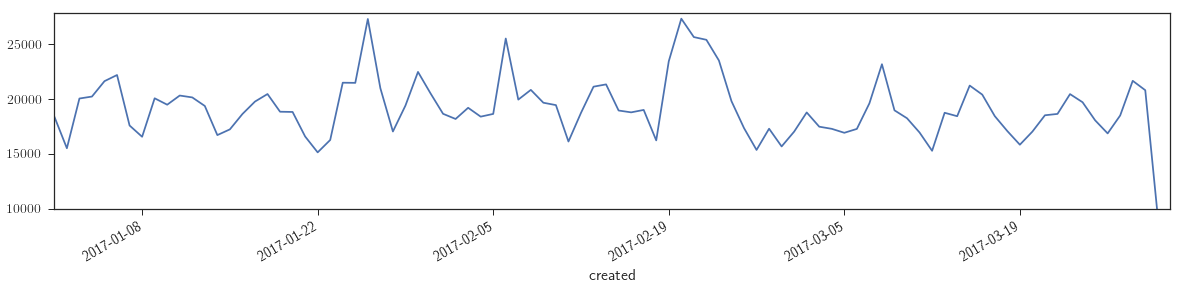

In [14]:
import datetime
ds2=ds[['id','created']]
ds2=ds2[ds2.created > datetime.date(2016,12,31)]
ds2=ds2[ds2.created < datetime.date(2017,4,1)]
ts=ds2.groupby('created').size()
fig=plt.figure(figsize=(20,4))
ts.plot()
fig.autofmt_xdate()
plt.ylim([10000, ts.max()+500])

In [ ]:
nonconv_tweets = ds[(ds.in_reply_to_status_id.isnull()) & (ds.num_replies==1)]
sample = nonconv_tweets.sample(2000).copy()
dt=sample.timestamp.dt.tz_localize('UTC')
sample['timestamp'] = dt.dt.tz_convert('America/Guayaquil')
sample['hour'] = sample.timestamp.dt.hour
sample['weekday'] = sample.timestamp.dt.weekday
sns.kdeplot(sample.weekday, sample.hour, shade=True)

In [ ]:
import calendar

In [ ]:
plt.figure(figsize=(10,8))
root_tweets = ds[(ds.in_reply_to_status_id.isnull()) & (ds.num_replies>1)]
sample = root_tweets.sample(5000)
dt=sample.timestamp.dt.tz_localize('UTC')
sample['timestamp'] = dt.dt.tz_convert('America/Guayaquil')
sample['hour'] = sample.timestamp.dt.hour
sample['weekday'] = sample.timestamp.dt.weekday
ax = sns.kdeplot(sample.weekday, sample.hour, shade=True)
labels=list(calendar.day_name)
labels.insert(0,'')
labels.insert(0,'')
labels.append('')
labels.append('')
ax.set_xticklabels(labels)
plt.xticks(rotation=45)
plt.xlabel('')
plt.yticks(np.arange(min(sample.hour), max(sample.hour)+1, 2))
plt.tight_layout()
plt.savefig('results/temporal_distribution.eps', format='eps')

In [ ]:
conv = conversation_filter(ds)
conv.shape

In [ ]:
span = conv.groupby('conversation_id').agg({'id': 'count', 'timestamp': ['min', 'max']})
span.head()

In [ ]:
spands = span.reset_index()
spands.columns=spands.columns.droplevel(0)
spands.columns=['conversation_id', 'count', 'min', 'max']
#spands['elapsed'] = spands.apply(lambda r: (r['max']-r['min']).days,1)
spands['elapsed'] = spands['max'] - spands['min']
spands['elapsed_days'] = spands['elapsed']/np.timedelta64(1, 'D')
spands.sort_values('elapsed_days', ascending=False).head()

In [ ]:
y, bins = np.histogram(spands.elapsed_days, bins=100)
x = bins[:-1]
x.shape

In [ ]:
y_log = np.log(y)
x_log = np.log(x)
plt.scatter(x_log, y_log, marker='.')


In [ ]:
spands['elapsed_summary'] = np.round(spands.elapsed_days/10)*10
span_group = spands.groupby('elapsed_summary').size()
span_group = span_group.reset_index()
span_group.columns =['from', 'conversations']
total = span_group.conversations.sum()
span_group['to'] = span_group['from'].shift(-1)
span_group['perc'] = span_group.conversations / total
span_group['cperc'] = span_group.conversations.cumsum() / total
span_group = span_group.head()
span_group = span_group[['from','to', 'conversations', 'perc','cperc']]
span_group.to_csv('results/conv_span.csv',index=False)
span_group
#span_group = span_group[]
#span_group.plot.box()

In [ ]:
spands.elapsed_days.plot.hist(bins=50)
plt.yscale('log')
plt.xlabel('days')
plt.tight_layout()
plt.savefig('results/conv_duration.eps', format='eps')

long conversation sample:

In [ ]:
conv[conv.conversation_id==1293412597][['timestamp','screen_name','text']].values

In [ ]:
conv[conv.conversation_id==5157432533][['timestamp','screen_name','text']].values

short conversations sample:

In [ ]:
spands.sort_values('elapsed_days', ascending=True).head()

In [ ]:
conv[conv.conversation_id==823598851164672003][['timestamp','screen_name','text']].values